In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind 
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scipy.stats import normaltest

import matplotlib.pyplot as plt 
import seaborn as sns

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 500)

In [2]:
ecmodf_analysis = pd.read_csv('ecmodf_analysis_manualedits.csv', index_col=0)
ecmodf_analysis['sex'] = ecmodf_analysis['sex'].astype('bool')
ecmodf_analysis['death'] = ecmodf_analysis['death'].astype('bool')
ecmodf_analysis['rrt'] = ecmodf_analysis['rrt'].astype('bool')
ecmodf_analysis['ptx'] = ecmodf_analysis['ptx'].astype('bool')
ecmodf_analysis['pe'] = ecmodf_analysis['pe'].astype('bool')
ecmodf_analysis['bronchinf'] = ecmodf_analysis['bronchinf'].astype('bool')
ecmodf_analysis['ethnic'] = ecmodf_analysis['ethnic'].astype('object')
del ecmodf_analysis['admit_date']
del ecmodf_analysis['hosp']

ecmodf_comorb = pd.read_csv('ecmodf_analysis_comorb.csv', index_col=0)
ecmodf_steroids = pd.read_csv('ecmodf_analysis_steroids.csv', index_col=0)
ecmodf_analysis = pd.concat([ecmodf_analysis, ecmodf_comorb], axis=1)
ecmodf_analysis = pd.concat([ecmodf_analysis, ecmodf_steroids], axis=1)

In [3]:
ecmodf_analysis.head()

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim,cluster,sex,death,time,ethnic,resp,na,rrt,pe,ptx,deathmod,cth,bronch0,bronchinf,diabetes,asthma,hypertension,presteroid,ecmosteroid,ttsteroids
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46,34,3.0,2,4,48.750000,6.0000,29.00,0.4,24.0,0.800000,1609,306,7.2,10.3,2,False,False,21,2,6,0.48,True,False,True,NaN,NaN,NaN,False,0,1,0,0,0,NaN
2,34,37,6.0,1,4,76.500000,9.8918,29.36,0.5,31.2,12.336727,115,217,4.1,80.0,2,True,False,12,1,7,0.10,False,False,False,NaN,NaN,NaN,False,0,0,0,0,0,NaN
3,66,26,6.0,1,10,61.578947,7.5500,28.00,0.3,19.3,6.290000,5534,409,7.1,80.0,2,False,False,12,0,4,0.94,True,True,False,NaN,NaN,NaN,False,0,0,0,0,1,3.0
4,34,36,0.0,2,6,72.187500,7.1000,30.00,1.9,9.6,1.210000,267,388,7.1,7.4,1,True,False,19,2,5,0.08,False,False,False,NaN,NaN,candida,False,0,1,0,0,1,8.0
5,53,42,1.0,2,12,80.833333,9.3000,31.00,0.8,7.4,100.000000,6023,665,5.9,73.3,0,False,True,13,1,3,0.45,True,False,True,death_mof,NaN,NaN,False,0,0,1,0,1,4.0


In [4]:
ecmodf_analysis['cluster'].value_counts() #counts numbers in each cluster

1    24
0    20
2    12
Name: cluster, dtype: int64

## Survival comparison

In [5]:
##DO NOT DROP COLUMNS use for later subanalysis

ecmodf_analysis = pd.concat([ecmodf_analysis, pd.get_dummies(ecmodf_analysis['ethnic'], prefix='ethnic')], axis=1)

ecmodf_analysis = pd.concat([ecmodf_analysis, pd.get_dummies(ecmodf_analysis['cth'])], axis=1)

ecmodf_analysis = pd.concat([ecmodf_analysis, pd.get_dummies(ecmodf_analysis['deathmod'])], axis=1)

ecmodf_analysis.head()

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim,cluster,sex,death,time,ethnic,resp,na,rrt,pe,ptx,deathmod,cth,bronch0,bronchinf,diabetes,asthma,hypertension,presteroid,ecmosteroid,ttsteroids,ethnic_0,ethnic_1,ethnic_2,cth_bleed,cth_stroke,death_bleed,death_ich,death_mof,death_stroke,death_tamponade,death_withdraw
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46,34,3.0,2,4,48.750000,6.0000,29.00,0.4,24.0,0.800000,1609,306,7.2,10.3,2,False,False,21,2,6,0.48,True,False,True,NaN,NaN,NaN,False,0,1,0,0,0,NaN,0,0,1,0,0,0,0,0,0,0,0
2,34,37,6.0,1,4,76.500000,9.8918,29.36,0.5,31.2,12.336727,115,217,4.1,80.0,2,True,False,12,1,7,0.10,False,False,False,NaN,NaN,NaN,False,0,0,0,0,0,NaN,0,1,0,0,0,0,0,0,0,0,0
3,66,26,6.0,1,10,61.578947,7.5500,28.00,0.3,19.3,6.290000,5534,409,7.1,80.0,2,False,False,12,0,4,0.94,True,True,False,NaN,NaN,NaN,False,0,0,0,0,1,3.0,1,0,0,0,0,0,0,0,0,0,0
4,34,36,0.0,2,6,72.187500,7.1000,30.00,1.9,9.6,1.210000,267,388,7.1,7.4,1,True,False,19,2,5,0.08,False,False,False,NaN,NaN,candida,False,0,1,0,0,1,8.0,0,0,1,0,0,0,0,0,0,0,0
5,53,42,1.0,2,12,80.833333,9.3000,31.00,0.8,7.4,100.000000,6023,665,5.9,73.3,0,False,True,13,1,3,0.45,True,False,True,death_mof,NaN,NaN,False,0,0,1,0,1,4.0,0,1,0,0,0,0,0,1,0,0,0


In [6]:
cat = ['sex', 'death', 'bronchinf', 'rrt', 'pe', 'ptx', 'ethnic_0', 'ethnic_1', 'ethnic_2', 'cth_bleed', 'cth_stroke', 'death_bleed', 'death_mof', 'death_stroke', 'death_tamponade', 'death_withdraw', 'asthma', 'diabetes', 'hypertension', 'presteroid', 'ecmosteroid']
con = ['age', 'bmi', 'ed_v', 'v_vv', 'sofa', 'pfr', 'pco2', 'pplat', 'lymph', 'nlrat', 'pct', 'ferritin', 'crp', 'fib', 'ddim', 'na', 'time', 'resp', 'ttsteroids'] 

pop1 = ecmodf_analysis[ecmodf_analysis.death == 0]
pop0 = ecmodf_analysis[ecmodf_analysis.death == 1]


In [7]:
def iqr(series):
    q75, q25 = np.percentile(series.dropna(), [75 ,25]) #include dropna because np.percentile doesn't play nice with NaN
    return str("[" + str(np.round(q25, decimals=1)) + " - " + str(np.round(q75, decimals=1)) + "]")

In [8]:
cohort_summ = pd.DataFrame(index=['pop', 'alive', 'dead', 'p'], columns = cat + con)

In [9]:
for column in cohort_summ.columns:
    for row in cohort_summ.index:
        
        if row == 'pop':
            if column in cat:
                count = ecmodf_analysis[column].sum()
                percent = np.round((count / (len(ecmodf_analysis[column]) - ecmodf_analysis[column].isnull().sum())) * 100, decimals=1)
                cohort_summ.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(ecmodf_analysis[column].median(axis=0), decimals=1)
                cohort_summ.loc[row, column] = str(median) + ' ' + iqr(ecmodf_analysis[column])
                
        elif row == 'alive':
            if column in cat:
                count = pop1[column].sum()
                percent = np.round((count / (len(pop1[column]) - pop1[column].isnull().sum())) * 100, decimals=1)
                cohort_summ.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(pop1[column].median(axis=0), decimals=1)
                cohort_summ.loc[row, column] = str(median) + ' ' + iqr(pop1[column])
                
        elif row == 'dead':
            if column in cat:
                count = pop0[column].sum()
                percent = np.round((count / (len(pop0[column]) - pop0[column].isnull().sum())) * 100, decimals=1)
                cohort_summ.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(pop0[column].median(axis=0), decimals=1)
                cohort_summ.loc[row, column] = str(median) + ' ' + iqr(pop0[column])  
                

In [10]:
for i in con:
    sval, pval = mannwhitneyu(pop1[i].dropna(), pop0[i].dropna(), alternative = 'two-sided')
    cohort_summ.loc['p', i] = np.round(pval, decimals = 6)
    
for i in cat:
    try:
        OR, p = fisher_exact(pd.crosstab(ecmodf_analysis['death'], ecmodf_analysis[i].dropna()))
        cohort_summ.loc['p', i] = np.round(p, decimals = 6)
    except:
        stat, p, dof, expected = chi2_contingency(pd.crosstab(ecmodf_analysis['death'], ecmodf_analysis[i].dropna()))
        cohort_summ.loc['p', i] = np.round(p, decimals = 6)

In [11]:
cohort_summ.transpose()

,pop,alive,dead,p
sex,15 (26.8%),14 (35.0%),1 (6.2%),0.043135
death,16 (28.6%),0 (0.0%),16 (100.0%),0
bronchinf,10 (17.9%),7 (17.5%),3 (18.8%),1
rrt,22 (39.3%),13 (32.5%),9 (56.2%),0.133706
pe,15 (26.8%),8 (20.0%),7 (43.8%),0.097265
ptx,15 (26.8%),9 (22.5%),6 (37.5%),0.320831
ethnic_0,23 (41.1%),16 (40.0%),7 (43.8%),1
ethnic_1,11 (19.6%),7 (17.5%),4 (25.0%),0.710772
ethnic_2,22 (39.3%),17 (42.5%),5 (31.2%),0.55031
cth_bleed,7 (12.5%),4 (10.0%),3 (18.8%),0.39472


## Clusters initial analysis

In [12]:
deathmod = pd.crosstab(ecmodf_analysis['cluster'], ecmodf_analysis['deathmod'])
deathmod

deathmod,death_bleed,death_ich,death_mof,death_stroke,death_tamponade,death_withdraw
cluster,,,,,,
0,1,1,6,0,1,0
1,0,0,0,1,0,0
2,0,1,1,1,1,2


In [13]:
for i in deathmod.columns:
    stat, pval, dof, expected = chi2_contingency(pd.crosstab(ecmodf_analysis['cluster'], ecmodf_analysis[i]))
    if pval < 0.05:
        print("There is a significant difference in " + str(i) + " between clusters - pval = " + str(pval))
    else:
        print("There is NOT a significant difference in " + str(i) + " between clusters - pval = " + str(pval))

There is NOT a significant difference in death_bleed between clusters - pval = 0.3999708392671946
There is NOT a significant difference in death_ich between clusters - pval = 0.4070719075578556
There is a significant difference in death_mof between clusters - pval = 0.009956558397450594
There is NOT a significant difference in death_stroke between clusters - pval = 0.4594258240359268
There is NOT a significant difference in death_tamponade between clusters - pval = 0.4070719075578556
There is a significant difference in death_withdraw between clusters - pval = 0.02231560351953266


In [14]:
ctfinds = pd.crosstab(ecmodf_analysis['cluster'], ecmodf_analysis['cth'])
ctfinds

cth,cth_bleed,cth_stroke
cluster,,
0,5,0
1,2,1
2,0,3


In [15]:
for i in ctfinds.columns:
    stat, pval, dof, expected = chi2_contingency(pd.crosstab(ecmodf_analysis['cluster'], ecmodf_analysis[i]))
    if pval < 0.05:
        print("There is a significant difference in " + str(i) + " between clusters - pval = " + str(pval))
    else:
        print("There is NOT a significant difference in " + str(i) + " between clusters - pval = " + str(pval))

There is NOT a significant difference in cth_bleed between clusters - pval = 0.08406285583693758
There is a significant difference in cth_stroke between clusters - pval = 0.022057500766838933


In [16]:
firstbronch = pd.crosstab(ecmodf_analysis['cluster'], ecmodf_analysis['bronch0'])
firstbronch

bronch0,aspergillus,candida,ecoli,efaecalis,enterobacter,klebsiella
cluster,,,,,,
0,1,4,1,1,0,3
1,0,4,0,0,1,3
2,0,2,0,0,0,0


In [17]:
ecmodf_analysis = pd.concat([ecmodf_analysis, pd.get_dummies(ecmodf_analysis['bronch0'])], axis=1)
ecmodf_analysis.drop('bronch0', inplace=True, axis=1)

In [18]:
for i in firstbronch.columns:
    stat, pval, dof, expected = chi2_contingency(pd.crosstab(ecmodf_analysis['cluster'], ecmodf_analysis[i]))
    if pval < 0.05:
        print("There is a significant difference in " + str(i) + " between clusters - pval = " + str(pval))
    else:
        print("There is NOT a significant difference in " + str(i) + " between clusters - pval = " + str(pval))

There is NOT a significant difference in aspergillus between clusters - pval = 0.3999708392671946
There is NOT a significant difference in candida between clusters - pval = 0.9524709680589699
There is NOT a significant difference in ecoli between clusters - pval = 0.3999708392671946
There is NOT a significant difference in efaecalis between clusters - pval = 0.3999708392671946
There is NOT a significant difference in enterobacter between clusters - pval = 0.5072314458893004
There is NOT a significant difference in klebsiella between clusters - pval = 0.385968314374242


In [19]:
pathbronch = pd.crosstab(ecmodf_analysis['cluster'], ecmodf_analysis['bronchinf'])
stat, pval, dof, expected = chi2_contingency(pathbronch)
print("p = " + str(pval))
pathbronch

p = 0.09815971124213452


bronchinf,False,True
cluster,,
0,14,6
1,20,4
2,12,0


## Generate three-way results table

In [20]:
ecmodf_analysis.head()

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim,cluster,sex,death,time,ethnic,resp,na,rrt,pe,ptx,...,cth,bronchinf,diabetes,asthma,hypertension,presteroid,ecmosteroid,ttsteroids,ethnic_0,ethnic_1,ethnic_2,cth_bleed,cth_stroke,death_bleed,death_ich,death_mof,death_stroke,death_tamponade,death_withdraw,aspergillus,candida,ecoli,efaecalis,enterobacter,klebsiella
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46,34,3.0,2,4,48.750000,6.0000,29.00,0.4,24.0,0.800000,1609,306,7.2,10.3,2,False,False,21,2,6,0.48,True,False,True,...,NaN,False,0,1,0,0,0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,37,6.0,1,4,76.500000,9.8918,29.36,0.5,31.2,12.336727,115,217,4.1,80.0,2,True,False,12,1,7,0.10,False,False,False,...,NaN,False,0,0,0,0,0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66,26,6.0,1,10,61.578947,7.5500,28.00,0.3,19.3,6.290000,5534,409,7.1,80.0,2,False,False,12,0,4,0.94,True,True,False,...,NaN,False,0,0,0,0,1,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,34,36,0.0,2,6,72.187500,7.1000,30.00,1.9,9.6,1.210000,267,388,7.1,7.4,1,True,False,19,2,5,0.08,False,False,False,...,NaN,False,0,1,0,0,1,8.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,53,42,1.0,2,12,80.833333,9.3000,31.00,0.8,7.4,100.000000,6023,665,5.9,73.3,0,False,True,13,1,3,0.45,True,False,True,...,NaN,False,0,0,1,0,1,4.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [21]:
# Split into separate dataframes for each cluster
ecmoclus0 = ecmodf_analysis[ecmodf_analysis.cluster == 0] #split off into separate cluster dfs
ecmoclus1 = ecmodf_analysis[ecmodf_analysis.cluster == 1]
ecmoclus2 = ecmodf_analysis[ecmodf_analysis.cluster == 2]

In [22]:
con = ['age', 'bmi', 'ed_v', 'v_vv', 'sofa', 'pfr', 'pco2', 'pplat', 'lymph', 'nlrat', 'pct', 'ferritin', 'crp', 'fib', 'ddim', 'time', 'na', 'resp', 'ttsteroids']

cat = ['death', 'sex', 'rrt', 'pe', 'ptx', 'diabetes', 'asthma', 'hypertension', 'death_bleed', 'ethnic_0', 'ethnic_1', 'ethnic_2',  'death_ich', 'death_mof', 'death_stroke', 'death_tamponade', 'death_withdraw', 'cth_bleed', 'cth_stroke', 'bronchinf','presteroid', 'ecmosteroid']


In [23]:
def iqr(series):
    q75, q25 = np.percentile(series.dropna(), [75 ,25]) #include dropna because np.percentile doesn't play nice with NaN
    return str("[" + str(np.round(q25, decimals=1)) + " - " + str(np.round(q75, decimals=1)) + "]")

iqr(ecmodf_analysis['age']) #test

'[37.5 - 52.2]'

In [24]:
ecmodf_final = pd.DataFrame(index=['all', 'C0', 'C1', 'C2', 'p'], columns = con + cat)
ecmodf_final

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim,time,na,resp,ttsteroids,death,sex,rrt,pe,ptx,diabetes,asthma,hypertension,death_bleed,ethnic_0,ethnic_1,ethnic_2,death_ich,death_mof,death_stroke,death_tamponade,death_withdraw,cth_bleed,cth_stroke,bronchinf,presteroid,ecmosteroid
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
for column in ecmodf_final.columns:
    for row in ecmodf_final.index:
        
        if row == 'all':
            if column in cat:
                count = ecmodf_analysis[column].sum()
                percent = np.round((count / (len(ecmodf_analysis[column]) - ecmodf_analysis[column].isnull().sum())) * 100, decimals=1)
                ecmodf_final.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(ecmodf_analysis[column].median(axis=0), decimals=1)
                ecmodf_final.loc[row, column] = str(median) + ' ' + iqr(ecmodf_analysis[column])
                
        elif row == 'C0':
            if column in cat:
                count = ecmoclus0[column].sum()
                percent = np.round((count / (len(ecmoclus0[column]) - ecmoclus0[column].isnull().sum())) * 100, decimals=1)
                ecmodf_final.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(ecmoclus0[column].median(axis=0), decimals=1)
                ecmodf_final.loc[row, column] = str(median) + ' ' + iqr(ecmoclus0[column])
                
        elif row == 'C1':
            if column in cat:
                count = ecmoclus1[column].sum()
                percent = np.round((count / (len(ecmoclus1[column]) - ecmoclus1[column].isnull().sum())) * 100, decimals=1)
                ecmodf_final.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(ecmoclus1[column].median(axis=0), decimals=1)
                ecmodf_final.loc[row, column] = str(median) + ' ' + iqr(ecmoclus1[column])    
    
        elif row == 'C2':
            if column in cat:
                count = ecmoclus2[column].sum()
                percent = np.round((count / (len(ecmoclus2[column]) - ecmoclus2[column].isnull().sum())) * 100, decimals=1)
                ecmodf_final.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(ecmoclus2[column].median(axis=0), decimals=1)
                ecmodf_final.loc[row, column] = str(median) + ' ' + iqr(ecmoclus2[column])    


In [26]:
for i in con:
    stat, pval = kruskal(ecmoclus0[i].dropna(), ecmoclus1[i].dropna(), ecmoclus2[i].dropna())
    ecmodf_final.loc['p', i] = np.round(pval, decimals = 6)

for i in cat:
    try:
        OR, p = fisher_exact(pd.crosstab(ecmodf_analysis['cluster'], ecmodf_analysis[i].dropna()))
        ecmodf_final.loc['p', i] = np.round(p, decimals = 6)
    except:
        stat, p, dof, expected = chi2_contingency(pd.crosstab(ecmodf_analysis['cluster'], ecmodf_analysis[i].dropna()))
        ecmodf_final.loc['p', i] = np.round(p, decimals = 6)

In [27]:
ecmodf_final.transpose()

,all,C0,C1,C2,p
age,46.0 [37.5 - 52.2],51.0 [45.2 - 53.0],41.0 [34.8 - 48.0],49.0 [44.8 - 54.2],0.01153
bmi,29.5 [27.0 - 34.0],29.5 [27.0 - 33.5],29.0 [26.8 - 34.2],32.0 [29.0 - 34.0],0.621015
ed_v,2.0 [0.8 - 4.0],1.0 [0.0 - 3.0],1.0 [0.0 - 4.0],6.0 [3.0 - 8.2],0.000424
v_vv,4.0 [1.8 - 6.0],6.0 [5.0 - 6.0],3.5 [2.0 - 5.2],1.0 [1.0 - 1.0],1e-06
sofa,6.0 [4.0 - 9.0],8.0 [5.8 - 11.2],4.5 [4.0 - 6.0],6.5 [4.0 - 9.0],0.00637
pfr,69.0 [59.8 - 78.8],65.6 [58.5 - 73.2],73.9 [67.5 - 88.6],59.9 [51.0 - 69.8],0.003528
pco2,9.0 [7.2 - 9.9],9.6 [7.8 - 11.6],8.9 [7.1 - 9.4],8.8 [7.5 - 9.9],0.313801
pplat,30.0 [27.8 - 31.2],31.0 [30.0 - 32.2],30.0 [25.8 - 31.0],29.2 [27.8 - 29.4],0.019586
lymph,0.6 [0.5 - 1.0],0.8 [0.6 - 1.2],0.6 [0.5 - 1.1],0.4 [0.4 - 0.6],0.012794
nlrat,13.9 [9.3 - 22.0],10.6 [7.6 - 16.3],11.8 [9.5 - 16.9],23.2 [19.3 - 34.1],0.000582


## Clus0 vs Clus2

In [28]:
ecmodf_0v2 = pd.DataFrame(index=['C0', 'C2', 'p'], columns = con + cat)

for column in ecmodf_0v2.columns:
    for row in ecmodf_0v2.index:
        
        if row == 'C0':
            if column in cat:
                count = ecmoclus0[column].sum()
                percent = np.round((count / (len(ecmoclus0[column]) - ecmoclus0[column].isnull().sum())) * 100, decimals=1)
                ecmodf_0v2.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(ecmoclus0[column].median(axis=0), decimals=1)
                ecmodf_0v2.loc[row, column] = str(median) + ' ' + iqr(ecmoclus0[column])
 
        elif row == 'C2':
            if column in cat:
                count = ecmoclus2[column].sum()
                percent = np.round((count / (len(ecmoclus2[column]) - ecmoclus2[column].isnull().sum())) * 100, decimals=1)
                ecmodf_0v2.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(ecmoclus2[column].median(axis=0), decimals=1)
                ecmodf_0v2.loc[row, column] = str(median) + ' ' + iqr(ecmoclus2[column])    
                
for i in con:
    sval, pval = mannwhitneyu(ecmoclus0[i].dropna(), ecmoclus2[i].dropna(), alternative = 'two-sided')
    ecmodf_0v2.loc['p', i] = np.round(pval, decimals = 6)

tempanalysis = ecmoclus0.append(ecmoclus2)
    
for i in cat:
#    try:
    OR, p = fisher_exact(pd.crosstab(tempanalysis['cluster'], tempanalysis[i].dropna()))
    ecmodf_0v2.loc['p', i] = np.round(p, decimals = 6)
#    except:
#        stat, p, dof, expected = chi2_contingency(pd.crosstab(tempanalysis['cluster'], tempanalysis[i].dropna()))
#        ecmodf_0v2.loc['p', i] = np.round(p, decimals = 6)

In [29]:
ecmodf_0v2.transpose()

,C0,C2,p
age,51.0 [45.2 - 53.0],49.0 [44.8 - 54.2],0.891237
bmi,29.5 [27.0 - 33.5],32.0 [29.0 - 34.0],0.422717
ed_v,1.0 [0.0 - 3.0],6.0 [3.0 - 8.2],0.000193
v_vv,6.0 [5.0 - 6.0],1.0 [1.0 - 1.0],3e-06
sofa,8.0 [5.8 - 11.2],6.5 [4.0 - 9.0],0.139496
pfr,65.6 [58.5 - 73.2],59.9 [51.0 - 69.8],0.329959
pco2,9.6 [7.8 - 11.6],8.8 [7.5 - 9.9],0.25801
pplat,31.0 [30.0 - 32.2],29.2 [27.8 - 29.4],0.009759
lymph,0.8 [0.6 - 1.2],0.4 [0.4 - 0.6],0.004174
nlrat,10.6 [7.6 - 16.3],23.2 [19.3 - 34.1],0.000427


## Positive bronch results

In [30]:
ecmobronch0 = ecmodf_analysis[ecmodf_analysis.bronchinf == False] #split off into separate cluster dfs
ecmobronch1 = ecmodf_analysis[ecmodf_analysis.bronchinf == True]

In [31]:
cat2 = ['death', 'sex', 'rrt', 'pe', 'ptx', 'death_bleed', 'death_ich', 'death_mof', 'death_stroke', 'death_tamponade', 'death_withdraw']

ecmodf_bronch = pd.DataFrame(index=['bronch0', 'bronch1', 'p'], columns = con + cat2)
ecmodf_bronch

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim,time,na,resp,ttsteroids,death,sex,rrt,pe,ptx,death_bleed,death_ich,death_mof,death_stroke,death_tamponade,death_withdraw
bronch0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bronch1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
for column in ecmodf_bronch.columns:
    for row in ecmodf_bronch.index:
        
        if row == 'bronch0':
            if column in cat:
                count = ecmobronch0[column].sum()
                percent = np.round((count / (len(ecmobronch0[column]) - ecmobronch0[column].isnull().sum())) * 100, decimals=1)
                ecmodf_bronch.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(ecmobronch0[column].median(axis=0), decimals=1)
                ecmodf_bronch.loc[row, column] = str(median) + ' ' + iqr(ecmobronch0[column])
 
        elif row == 'bronch1':
            if column in cat:
                count = ecmobronch1[column].sum()
                percent = np.round((count / (len(ecmobronch1[column]) - ecmobronch1[column].isnull().sum())) * 100, decimals=1)
                ecmodf_bronch.loc[row, column] = str(count) + " (" + str(percent) + "%)"
            if column in con:
                median = np.round(ecmoclus2[column].median(axis=0), decimals=1)
                ecmodf_bronch.loc[row, column] = str(median) + ' ' + iqr(ecmobronch1[column])    
                
for i in con:
    sval, pval = mannwhitneyu(ecmobronch0[i].dropna(), ecmobronch1[i].dropna(), alternative = 'two-sided')
    ecmodf_bronch.loc['p', i] = np.round(pval, decimals = 6)
    
for i in cat2:
    try:
        OR, p = fisher_exact(pd.crosstab(ecmodf_analysis['bronchinf'], ecmodf_analysis[i].dropna()))
        ecmodf_bronch.loc['p', i] = np.round(p, decimals = 6)
    except:
        stat, p, dof, expected = chi2_contingency(pd.crosstab(ecmodf_analysis['bronchinf'], ecmodf_analysis[i].dropna()))
        ecmodf_bronch.loc['p', i] = np.round(p, decimals = 6)
        

In [33]:
ecmodf_bronch.transpose()

,bronch0,bronch1,p
age,45.5 [35.2 - 52.0],49.0 [48.0 - 53.8],0.06061
bmi,30.0 [27.2 - 34.8],32.0 [24.2 - 31.5],0.212801
ed_v,3.0 [1.0 - 5.0],6.0 [0.0 - 1.8],0.044767
v_vv,3.5 [1.0 - 5.8],1.0 [5.0 - 7.5],0.008541
sofa,6.0 [4.0 - 8.8],6.5 [5.0 - 9.8],0.291891
pfr,69.0 [58.7 - 77.5],59.9 [63.0 - 82.2],0.549031
pco2,9.2 [7.1 - 10.0],8.8 [8.6 - 9.6],0.534568
pplat,30.0 [28.2 - 32.0],29.2 [26.2 - 31.0],0.377826
lymph,0.6 [0.5 - 1.0],0.4 [0.5 - 0.9],0.714338
nlrat,13.5 [9.2 - 22.3],23.2 [10.4 - 18.3],0.813951


## Survival analysis

In [301]:
ecmodf_survival = pd.read_csv('ecmodf_analysis_time.csv', index_col=0)
ecmodf_survival.head()

,hosp,cluster,death,time,time2,hiferritin
id,,,,,,
1,6842347C,2,False,21,70,1
2,6844940J,2,False,12,70,0
3,6845871X,2,False,12,70,1
4,6849178A,1,False,19,70,0
5,5778383B,0,True,13,13,1


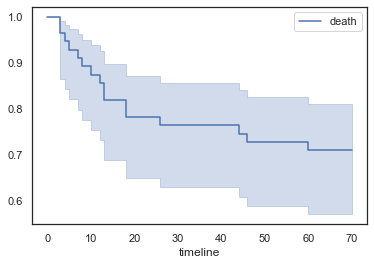

In [302]:
from lifelines import KaplanMeierFitter

alldeath = ecmodf_survival[['death', 'time2']].copy()

kmf = KaplanMeierFitter()
kmf.fit(alldeath['time2'], alldeath['death'], label = "death")
kmf.plot(ci_show = True)

In [303]:
timeclus0 = ecmodf_survival[ecmodf_survival.cluster == 0] #split off into separate cluster dfs
timeclus1 = ecmodf_survival[ecmodf_survival.cluster == 1]
timeclus2 = ecmodf_survival[ecmodf_survival.cluster == 2]

In [304]:
t0 = timeclus0['time2']
i0 = timeclus0['death']

t1 = timeclus1['time2']
i1 = timeclus1['death']

t2 = timeclus2['time2']
i2 = timeclus2['death']

Text(0.5, 0, 'Days after ECMO initiation')

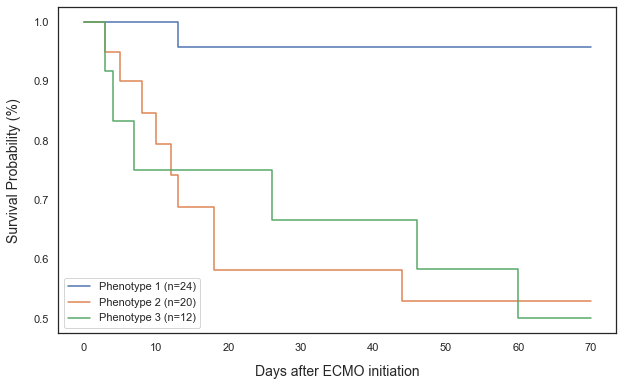

In [461]:
sns.set(style='white')

plt.figure(figsize=(10,6))

kmf.fit(t1, i1, label='Phenotype 1 (n=24)')
a1 = kmf.plot(ci_show = False)

kmf.fit(t0, i0, label='Phenotype 2 (n=20)')
a1 = kmf.plot(ci_show = False)

kmf.fit(t2, i2, label='Phenotype 3 (n=12)')
a1 = kmf.plot(ci_show = False)

a1.set_ylabel('Survival Probability (%)', fontsize=14, labelpad=12)
a1.set_xlabel('Days after ECMO initiation', fontsize=14, labelpad=12)


In [673]:
from lifelines import CoxPHFitter

ecmodf_cox = ecmodf_survival.drop(columns = ['hosp', 'time2'])

ecmodf_cox['SOFA score'] = ecmodf_analysis['sofa']

#ecmodf_cox['Ventilation days'] = ecmodf_analysis['v_vv']

#ecmodf_cox['Diabetes'] = ecmodf_analysis['diabetes']
#ecmodf_cox['Hypertension'] = ecmodf_analysis['hypertension']
#ecmodf_cox['Asthma'] = ecmodf_analysis['asthma']

ecmodf_cox['D-dimer (per doubling)'] = ecmodf_analysis['ddim']
ecmodf_cox['D-dimer (per doubling)'] = np.log2(ecmodf_cox['D-dimer (per doubling)'])

#ecmodf_cox['Ferritin (per doubling)'] = ecmodf_analysis['ferritin']
#ecmodf_cox['Ferritin (per doubling)'] = np.log2(ecmodf_cox['Ferritin (per doubling)'])

#ecmodf_cox['N:L ratio'] = ecmodf_analysis['nlrat']

#ecmodf_cox['HI group'] = ecmodf_cox['hiferritin']
ecmodf_cox.drop(['hiferritin'], inplace=True, axis=1)

ecmodf_cox['Body mass index'] = ecmodf_analysis['bmi']
ecmodf_cox['Age'] = ecmodf_analysis['age']
ecmodf_cox['RESP score'] = ecmodf_analysis['resp']

#ecmodf_cox['Procalcitonin (per doubling)'] = ecmodf_analysis['pct']
#ecmodf_cox['Procalcitonin (per doubling)'] = np.log2(ecmodf_cox['Procalcitonin (per doubling)'])

ecmodf_cox['sex'] = ecmodf_analysis['sex'] #1 = female
ecmodf_cox = pd.concat([ecmodf_cox, pd.get_dummies(ecmodf_cox['sex'], drop_first = False, prefix = 'female')], axis=1)
ecmodf_cox['Male sex'] = ecmodf_cox['female_False']
ecmodf_cox.drop(['sex', 'female_True', 'female_False'], inplace=True, axis=1)

ecmodf_cox['ethnic'] = ecmodf_analysis['ethnic'] #0 = white, #1 = black, #2 = other
ecmodf_cox = pd.concat([ecmodf_cox, pd.get_dummies(ecmodf_cox['ethnic'], prefix = 'ethnic')], axis=1)
ecmodf_cox['Black ethnicity (vs white)'] = ecmodf_cox['ethnic_1']
ecmodf_cox['Asian ethnicity (vs white)'] = ecmodf_cox['ethnic_2']
#ecmodf_cox['White ethnicity (vs other)'] = ecmodf_cox['ethnic_0']
ecmodf_cox.drop(['ethnic', 'ethnic_0', 'ethnic_2', 'ethnic_1'], inplace=True, axis=1)

#ecmodf_cox = pd.concat([ecmodf_cox, pd.get_dummies(ecmodf_cox['cluster'], prefix = 'cluster')], axis=1)
#ecmodf_cox.drop(['cluster', 'cluster_0', 'cluster_2'], inplace=True, axis=1)

ecmodf_cox.drop(['cluster'], inplace=True, axis=1)

ecmodf_cox


,death,time,SOFA score,D-dimer (per doubling),Body mass index,Age,RESP score,Male sex,Black ethnicity (vs white),Asian ethnicity (vs white)
id,,,,,,,,,,
1,False,21,4,3.364572,34,46,6,1,0,1
2,False,12,4,6.321928,37,34,7,0,1,0
3,False,12,10,6.321928,26,66,4,1,0,0
4,False,19,6,2.887525,36,34,5,0,0,1
5,True,13,12,6.195741,42,53,3,1,1,0
6,False,7,4,4.608809,28,55,2,1,1,0
7,True,5,10,5.551516,26,52,2,1,1,0
8,False,13,9,4.963474,22,57,3,1,1,0
9,True,3,13,5.449561,27,53,2,1,0,0


In [674]:
## Variance inflation factor to detect colinearity
## Linear relationships that exist between independent variables in model will cause coefficients (and HR) to be unstable
## By regression each variable against all other independent variables in table, can generate tolerance (1-R^2) and VIF (reciprocal of tolerance)
## VIF high = high multicollinearity 

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(ecmodf_cox) #requires constants column as reference(?)
X.drop(['death', 'time'], inplace=True, axis=1)


In [675]:
## No formal criteria, but values > 4 for VIF in any given variable suggest action is required
## VIF markedly different from other variables suggest action is required

pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                         98.747549
SOFA score                     1.328353
D-dimer (per doubling)         1.437941
Body mass index                1.259667
Age                            1.489749
RESP score                     1.590212
Male sex                       1.106711
Black ethnicity (vs white)     1.381238
Asian ethnicity (vs white)     1.393294
dtype: float64

In [676]:
cph = CoxPHFitter()

cph.fit(ecmodf_cox, 'time', event_col='death')

cph.print_summary()

## exp(coef) gives hazard ratios

<lifelines.CoxPHFitter: fitted with 56 total observations, 40 right-censored observations>
             duration col = 'time'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 56
number of events observed = 16
   partial log-likelihood = -32.26
         time fit was run = 2020-10-13 16:14:27 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
SOFA score                   0.30       1.35       0.14             0.04             0.57                 1.04                 1.76
D-dimer (per doubling)       0.63       1.87       0.24             0.15             1.10                 1.16                 3.01
Body mass index              0.00       1.00       0.06            -0.12             0.12                 0.89                 1.13
Age                         -0.08       0.92       0.06            -0.19             0.03                 0.83                 1.03
RESP score                  -0.95       0.39       0.47            -1.88            -0.02                 0.15                 0.98
Male sex                     1.15       3.14       1.15            -1.11             3.41                 0.33                30.15
Black ethnicity (vs white)  -1.70       0.18       0.99            -3.64             0.24                 0.03                 1.27
Asian ethnicity (vs white)   0.00       1.00       0.82            -1.61             1.61                 0.20                 5.02

                               z    p   -log2(p)
covariate                                       
SOFA score                  2.22 0.03       5.24
D-dimer (per doubling)      2.58 0.01       6.65
Body mass index             0.03 0.98       0.03
Age                        -1.42 0.15       2.70
RESP score                 -2.01 0.04       4.49
Male sex                    0.99 0.32       1.64
Black ethnicity (vs white) -1.72 0.09       3.55
Asian ethnicity (vs white)  0.00 1.00       0.00
---
Concordance = 0.88
Partial AIC = 80.53
log-likelihood ratio test = 31.60 on 8 df
-log2(p) of ll-ratio test = 13.15

In [677]:
cph.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 8
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          31.60 <0.005     13.15

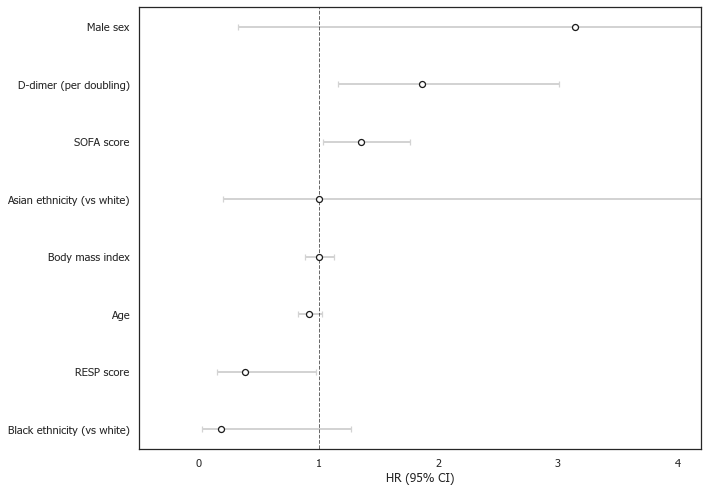

In [678]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma']

fig, ax = plt.subplots(figsize=(10, 7))

plt.xlim(-0.5, 4.2)

cph.plot(hazard_ratios=True, ax = ax, elinewidth = 2, capsize = 3, fmt='o', ecolor='lightgray')

#xlolims=True,

plt.tight_layout()

plt.savefig('figures/fig1.png')


In [685]:
### For partial effects charts for clusters

ecmodf_survival2 = pd.read_csv('ecmodf_analysis_survival.csv', index_col=0)

ecmodf_cox2 = ecmodf_survival2.drop(columns = ['hosp', 'time2', 'sofa', 'resp'])

ecmodf_cox2['SOFA score'] = ecmodf_survival2['sofa']

ecmodf_cox2['RESP score'] = ecmodf_survival2['resp']

ecmodf_cox2 = pd.concat([ecmodf_cox2, pd.get_dummies(ecmodf_cox2['cluster'], prefix = 'cluster')], axis=1)
ecmodf_cox2.drop(['cluster', 'cluster_2'], inplace=True, axis=1)

#ecmodf_cox2['Hyperinflammatory Cluster'] = ecmodf_survival2['hicluster']
#ecmodf_cox2.drop(['cluster', 'hicluster'], inplace=True, axis=1)



In [686]:
cph = CoxPHFitter()

cph.fit(ecmodf_cox2, 'time', event_col='death')

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 165 total observations, 117 right-censored observations>
             duration col = 'time'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 165
number of events observed = 48
   partial log-likelihood = -152.37
         time fit was run = 2020-10-13 16:15:55 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
SOFA score   0.18       1.20       0.06             0.06             0.30                 1.06                 1.35
RESP score  -0.43       0.65       0.16            -0.74            -0.12                 0.48                 0.89
cluster_0    1.09       2.98       0.58            -0.04             2.22                 0.96                 9.23
cluster_1   -1.66       0.19       0.72            -3.07            -0.26                 0.05                 0.77

               z      p   -log2(p)
covariate                         
SOFA score  2.99 <0.005       8.49
RESP score -2.71   0.01       7.22
cluster_0   1.89   0.06       4.10
cluster_1  -2.32   0.02       5.60
---
Concordance = 0.67
Partial AIC = 312.73
log-likelihood ratio test = 82.81 on 4 df
-log2(p) of ll-ratio test = 54.33

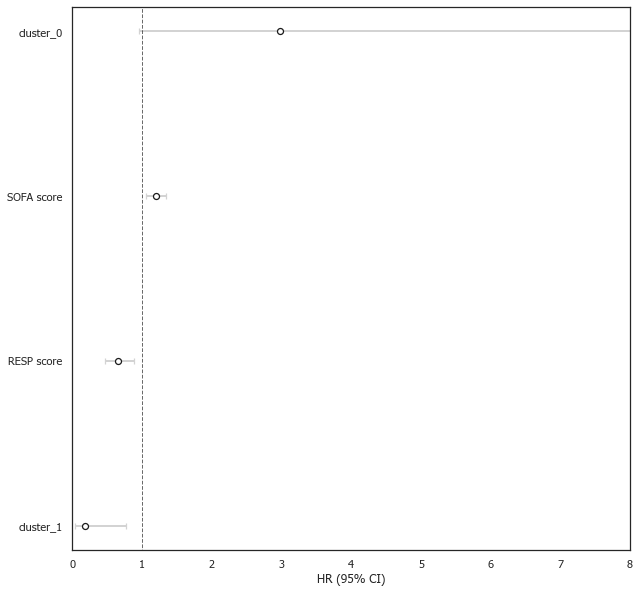

In [688]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.xlim(0, 8)

cph.plot(hazard_ratios=True, ax = ax, elinewidth = 2, capsize = 3, fmt='o', ecolor='lightgray')

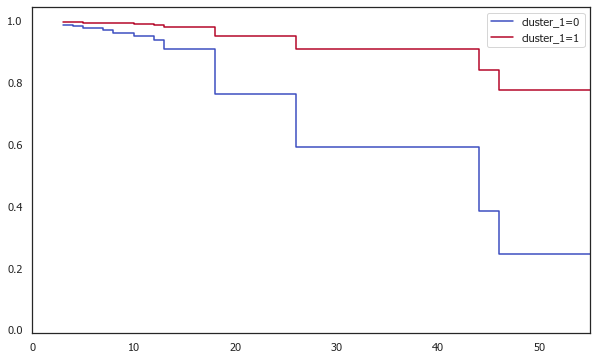

In [511]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.xlim(0, 55)

cph.plot_partial_effects_on_outcome(covariates='cluster_1', values=[0, 1], plot_baseline=False, ax=ax, cmap='coolwarm')




## Cluster vs Others

In [ ]:
# Setup data frames for mortality contingency tables
# Compare one cluster against the other two clusters

mort0 = pd.DataFrame(index=['Alive', 'Dead'], columns=['C0', 'Rest'])
mort1 = pd.DataFrame(index=['Alive', 'Dead'], columns=['C1', 'Rest'])
mort2 = pd.DataFrame(index=['Alive', 'Dead'], columns=['C2', 'Rest'])

mort0.loc['Alive','C0'] = (~ecmoclus0['death']).values.sum()
mort0.loc['Dead','C0'] = ecmoclus0['death'].values.sum()
mort0.loc['Alive','Rest'] = (~ecmoclus1['death']).values.sum() + (~ecmoclus2['death']).values.sum()
mort0.loc['Dead','Rest'] = ecmoclus1['death'].values.sum() + ecmoclus2['death'].values.sum()

mort1.loc['Alive','C1'] = (~ecmoclus1['death']).values.sum()
mort1.loc['Dead','C1'] = ecmoclus1['death'].values.sum()
mort1.loc['Alive','Rest'] = (~ecmoclus0['death']).values.sum() + (~ecmoclus2['death']).values.sum()
mort1.loc['Dead','Rest'] = ecmoclus0['death'].values.sum() + ecmoclus2['death'].values.sum()

mort2.loc['Alive','C2'] = (~ecmoclus2['death']).values.sum()
mort2.loc['Dead','C2'] = ecmoclus2['death'].values.sum()
mort2.loc['Alive','Rest'] = (~ecmoclus1['death']).values.sum() + (~ecmoclus0['death']).values.sum()
mort2.loc['Dead','Rest'] = ecmoclus1['death'].values.sum() + ecmoclus0['death'].values.sum()

print(mort0)
print(mort1)
print(mort2)

# Fisher exact test to compare mortality of each cluster vs the rest

mort0OR, mort0PVAL = fisher_exact(mort0)
mort1OR, mort1PVAL = fisher_exact(mort1)
mort2OR, mort2PVAL = fisher_exact(mort2)

if mort0PVAL <0.05:
    print("there is a significant difference between mortality in C0 and all other patients")
    print(mort0PVAL)
else:
    print("there is NOT a significant difference between mortality in C0 and all other patients")
    print(mort0PVAL)
    
if mort1PVAL <0.05:
    print("there is a significant difference between mortality in C1 and all other patients")
    print(mort1PVAL)
else:
    print("there is NOT a significant difference between mortality in C1 and all other patients")
    print(mort1PVAL)
    
if mort2PVAL <0.05:
    print("there is a significant difference between mortality in C2 and all other patients")
    print(mort2PVAL)
else:
    print("there is NOT a significant difference between mortality in C2 and all other patients")
    print(mort2PVAL)

In [ ]:
# Setup data frames for RRT contingency tables
# Compare one cluster against the other two clusters

rrt0 = pd.DataFrame(index=['RRT', 'No RRT'], columns=['C0', 'Rest'])
rrt1 = pd.DataFrame(index=['RRT', 'No RRT'], columns=['C1', 'Rest'])
rrt2 = pd.DataFrame(index=['RRT', 'No RRT'], columns=['C2', 'Rest'])

rrt0.loc['No RRT','C0'] = (~ecmoclus0['rrt']).values.sum()
rrt0.loc['RRT','C0'] = ecmoclus0['rrt'].values.sum()
rrt0.loc['No RRT','Rest'] = (~ecmoclus1['rrt']).values.sum() + (~ecmoclus2['rrt']).values.sum()
rrt0.loc['RRT','Rest'] = ecmoclus1['rrt'].values.sum() + ecmoclus2['rrt'].values.sum()

rrt1.loc['No RRT','C1'] = (~ecmoclus1['rrt']).values.sum()
rrt1.loc['RRT','C1'] = ecmoclus1['rrt'].values.sum()
rrt1.loc['No RRT','Rest'] = (~ecmoclus0['rrt']).values.sum() + (~ecmoclus2['rrt']).values.sum()
rrt1.loc['RRT','Rest'] = ecmoclus0['rrt'].values.sum() + ecmoclus2['rrt'].values.sum()

rrt2.loc['No RRT','C2'] = (~ecmoclus2['rrt']).values.sum()
rrt2.loc['RRT','C2'] = ecmoclus2['rrt'].values.sum()
rrt2.loc['No RRT','Rest'] = (~ecmoclus1['rrt']).values.sum() + (~ecmoclus0['death']).values.sum()
rrt2.loc['RRT','Rest'] = ecmoclus1['rrt'].values.sum() + ecmoclus0['death'].values.sum()

print(rrt0)
print(rrt1)
print(rrt2)

# Fisher exact test to compare RRT of each cluster vs the rest

rrt0OR, rrt0PVAL = fisher_exact(rrt0)
rrt1OR, rrt1PVAL = fisher_exact(rrt1)
rrt2OR, rrt2PVAL = fisher_exact(rrt2)

if rrt0PVAL <0.05:
    print("there is a significant difference between RRT in C0 and all other patients")
    print(rrt0PVAL)
else:
    print("there is NOT a significant difference between RRT in C0 and all other patients")
    print(rrt0PVAL)
    
if rrt1PVAL <0.05:
    print("there is a significant difference between RRT in C1 and all other patients")
    print(rrt1PVAL)
else:
    print("there is NOT a significant difference between RRT in C1 and all other patients")
    print(rrt1PVAL)
    
if rrt2PVAL <0.05:
    print("there is a significant difference between RRT in C2 and all other patients")
    print(rrt2PVAL)
else:
    print("there is NOT a significant difference between RRT in C2 and all other patients")
    print(rrt2PVAL)

In [ ]:
# Setup data frames for PE contingency tables
# Compare one cluster against the other two clusters

pe0 = pd.DataFrame(index=['pe', 'No pe'], columns=['C0', 'Rest'])
pe1 = pd.DataFrame(index=['pe', 'No pe'], columns=['C1', 'Rest'])
pe2 = pd.DataFrame(index=['pe', 'No pe'], columns=['C2', 'Rest'])

pe0.loc['No pe','C0'] = (~ecmoclus0['pe']).values.sum()
pe0.loc['pe','C0'] = ecmoclus0['pe'].values.sum()
pe0.loc['No pe','Rest'] = (~ecmoclus1['pe']).values.sum() + (~ecmoclus2['pe']).values.sum()
pe0.loc['pe','Rest'] = ecmoclus1['pe'].values.sum() + ecmoclus2['pe'].values.sum()

pe1.loc['No pe','C1'] = (~ecmoclus1['pe']).values.sum()
pe1.loc['pe','C1'] = ecmoclus1['pe'].values.sum()
pe1.loc['No pe','Rest'] = (~ecmoclus0['pe']).values.sum() + (~ecmoclus2['pe']).values.sum()
pe1.loc['pe','Rest'] = ecmoclus0['pe'].values.sum() + ecmoclus2['pe'].values.sum()

pe2.loc['No pe','C2'] = (~ecmoclus2['pe']).values.sum()
pe2.loc['pe','C2'] = ecmoclus2['pe'].values.sum()
pe2.loc['No pe','Rest'] = (~ecmoclus1['pe']).values.sum() + (~ecmoclus0['death']).values.sum()
pe2.loc['pe','Rest'] = ecmoclus1['pe'].values.sum() + ecmoclus0['death'].values.sum()

print(pe0)
print(pe1)
print(pe2)

# Fisher exact test to compare PE of each cluster vs the rest

pe0OR, pe0PVAL = fisher_exact(pe0)
pe1OR, pe1PVAL = fisher_exact(pe1)
pe2OR, pe2PVAL = fisher_exact(pe2)

if pe0PVAL <0.05:
    print("there is a significant difference between PE in C0 and all other patients")
    print(pe0PVAL)
else:
    print("there is NOT a significant difference between PE in C0 and all other patients")
    print(pe0PVAL)
    
if pe1PVAL <0.05:
    print("there is a significant difference between PE in C1 and all other patients")
    print(pe1PVAL)
else:
    print("there is NOT a significant difference between PE in C1 and all other patients")
    print(pe1PVAL)
    
if pe2PVAL <0.05:
    print("there is a significant difference between pe in C2 and all other patients")
    print(pe2PVAL)
else:
    print("there is NOT a significant difference between pe in C2 and all other patients")
    print(pe2PVAL)

In [ ]:
# Setup data frames for PTX contingency tables
# Compare one cluster against the other two clusters

ptx0 = pd.DataFrame(index=['ptx', 'No ptx'], columns=['C0', 'Rest'])
ptx1 = pd.DataFrame(index=['ptx', 'No ptx'], columns=['C1', 'Rest'])
ptx2 = pd.DataFrame(index=['ptx', 'No ptx'], columns=['C2', 'Rest'])

ptx0.loc['No ptx','C0'] = (~ecmoclus0['ptx']).values.sum()
ptx0.loc['ptx','C0'] = ecmoclus0['ptx'].values.sum()
ptx0.loc['No ptx','Rest'] = (~ecmoclus1['ptx']).values.sum() + (~ecmoclus2['ptx']).values.sum()
ptx0.loc['ptx','Rest'] = ecmoclus1['ptx'].values.sum() + ecmoclus2['ptx'].values.sum()

ptx1.loc['No ptx','C1'] = (~ecmoclus1['ptx']).values.sum()
ptx1.loc['ptx','C1'] = ecmoclus1['ptx'].values.sum()
ptx1.loc['No ptx','Rest'] = (~ecmoclus0['ptx']).values.sum() + (~ecmoclus2['ptx']).values.sum()
ptx1.loc['ptx','Rest'] = ecmoclus0['ptx'].values.sum() + ecmoclus2['ptx'].values.sum()

ptx2.loc['No ptx','C2'] = (~ecmoclus2['ptx']).values.sum()
ptx2.loc['ptx','C2'] = ecmoclus2['ptx'].values.sum()
ptx2.loc['No ptx','Rest'] = (~ecmoclus1['ptx']).values.sum() + (~ecmoclus0['death']).values.sum()
ptx2.loc['ptx','Rest'] = ecmoclus1['ptx'].values.sum() + ecmoclus0['death'].values.sum()

print(ptx0)
print(ptx1)
print(ptx2)

# Fisher exact test to compare ptx of each cluster vs the rest

ptx0OR, ptx0PVAL = fisher_exact(ptx0)
ptx1OR, ptx1PVAL = fisher_exact(ptx1)
ptx2OR, ptx2PVAL = fisher_exact(ptx2)

if ptx0PVAL <0.05:
    print("there is a significant difference between PTX in C0 and all other patients")
    print(ptx0PVAL)
else:
    print("there is NOT a significant difference between PTX in C0 and all other patients")
    print(ptx0PVAL)
    
if ptx1PVAL <0.05:
    print("there is a significant difference between PTX in C1 and all other patients")
    print(ptx1PVAL)
else:
    print("there is NOT a significant difference between PTX in C1 and all other patients")
    print(ptx1PVAL)
    
if ptx2PVAL <0.05:
    print("there is a significant difference between ptx in PTX and all other patients")
    print(ptx2PVAL)
else:
    print("there is NOT a significant difference between ptx in PTX and all other patients")
    print(ptx2PVAL)

In [ ]:
# Analysis of variance of medians between clusters using Kruskal-Wallis Test

print("""Compare for variance in medians between clusters
-------------------------------------------------
      """)

siglist = [] # initialis a list of significant values

for column in ecmoclus0:
    a = ecmoclus0[column]
    b = ecmoclus1[column]
    c = ecmoclus2[column]
    stat, pval = kruskal(a, b, c)
    if pval < 0.05:
        print(str(column) + " differences are statistically significant with a p-value of: " + str(pval))
        siglist += column
    if pval >0.05:
        print(str(column) + " difference are NOT statistically significant with a p-value of: " + str(pval))

In [ ]:
from pingouin import pairwise_gameshowell, read_dataset
pairwise_gameshowell(data=ecmodf_analysis, dv='ddim',
                     between='cluster')  